<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/my_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-18 18:58:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  16.5MB/s    in 50s     

2020-10-18 18:59:42 (12.9 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [2]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

--2020-10-18 18:59:42--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0.001s  

2020-10-18 18:59:43 (14.5 MB/s) - ‘data.py’ saved [10563/10563]



In [3]:
!mv data.py mydata.py

In [16]:
import math
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
import seaborn as sns
from mydata import Downloader, Parser
import matplotlib.pyplot as plt

In [5]:
torch.__version__

'1.6.0+cu101'

### **DATA**


In [9]:
data_path = './mydata/'

In [25]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [33]:
train = pd.read_csv('/content/drive/My Drive/dialogs_train.csv') 
valid = pd.read_csv('/content/drive/My Drive//dialogs_valid.csv') 

In [35]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

category2index = {category: index for index, category in enumerate(unique_categories)}

In [36]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [37]:
valid['target'][:3]

0    4
1    2
2    4
Name: target, dtype: int64

In [38]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [39]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### **Embeddings**

In [41]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            max_words = vocab_size if max_words <= 0 else max_words
            
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [42]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)



  0%|          | 0/100000 [00:00<?, ?it/s]

  1%|          | 908/100000 [00:00<00:10, 9072.91it/s]

  2%|▏         | 1732/100000 [00:00<00:11, 8796.33it/s]

  3%|▎         | 2611/100000 [00:00<00:11, 8792.86it/s]

  3%|▎         | 3466/100000 [00:00<00:11, 8717.43it/s]

  4%|▍         | 4158/100000 [00:00<00:11, 8082.72it/s]

  5%|▍         | 4899/100000 [00:00<00:12, 7868.28it/s]

  6%|▌         | 5726/100000 [00:00<00:11, 7983.30it/s]

  7%|▋         | 6583/100000 [00:00<00:11, 8149.38it/s]

  7%|▋         | 7431/100000 [00:00<00:11, 8244.62it/s]

  8%|▊         | 8235/100000 [00:01<00:11, 8180.47it/s]

  9%|▉         | 9073/100000 [00:01<00:11, 8236.76it/s]

 10%|▉         | 9902/100000 [00:01<00:10, 8250.13it/s]

 11%|█         | 10735/100000 [00:01<00:10, 8272.34it/s]

 12%|█▏        | 11555/100000 [00:01<00:10, 8118.49it/s]

 12%|█▏        | 12363/100000 [00:01<00:10, 8095.63it/s]

 13%|█▎        | 13170/100000 [00:01<00:10, 7899.78it/s]

 14%|█▍        | 14001/100000 [00:01<00

In [43]:
index2token = {index: token for token, index in vocab.items()}

In [44]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [45]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
x, y = train_dataset[0]

In [46]:
embeddings = torch.tensor(embeddings).float()
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
x_embed = embedding_layer(x)

In [47]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [48]:
for x, y in train_loader:
  print(x.size())
  print(y.size())
  break

torch.Size([128, 32])
torch.Size([128])


### **AVERAGE MODEL**

In [49]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        

        x = self.embedding_layer(x)
        x = x.sum(dim=1)
        x = self.batch_norm(x)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        
        x = self.linear_3(x)
        
        
        return x

In [50]:

model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [57]:
!pip install resources
!pip install staty

  Created wheel for staty: filename=staty-1.2.4-py2.py3-none-any.whl size=9560 sha256=38cc8f6440f525e6c14d3379caded8dbb1ba4d1bdbf828dd812323c73efc5b8f
  Stored in directory: /root/.cache/pip/wheels/b6/db/6d/fc04b3d621e28870ed142181fbc06fbc294fbc4e433f42bcd1
Successfully built staty


In [62]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [ ]:

epochs = 3
losses = []

# cm = confusion_matrix(train.targets, preds.argmax(dim=1))
for i in range(epochs):
  for x, y in train_loader:
    progress_bar = tqdm(total=len(train_loader))
    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.update()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")
  progress_bar.close()


Выходные данные были обрезаны до нескольких последних строк (5000).
  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<00:53, 36.23it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<00:55, 35.50it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<01:27, 22.39it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<01:56, 16.79it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<01:52, 17.40it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<01:37, 20.00it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<01:30, 21.65it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|          | 1/1954 [00:00<01:33, 20.95it/s]










  0%|          | 0/1954 [00:00<?, ?it/s]









  0%|     

epoch 0, loss 1.0310169458389282


Выходные данные были обрезаны до нескольких последних строк (5000).











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:38, 19.83it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:46, 18.42it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:33, 20.99it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:33, 20.79it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:38, 19.73it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:31, 21.42it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:35, 20.45it/s]











  0%|          | 0/1954 [00:00<?, ?it/s]










  0%|          | 1/1954 [00:00<01:51, 17.50it/s]











  0%|          | 0/1954 [00:00<?,

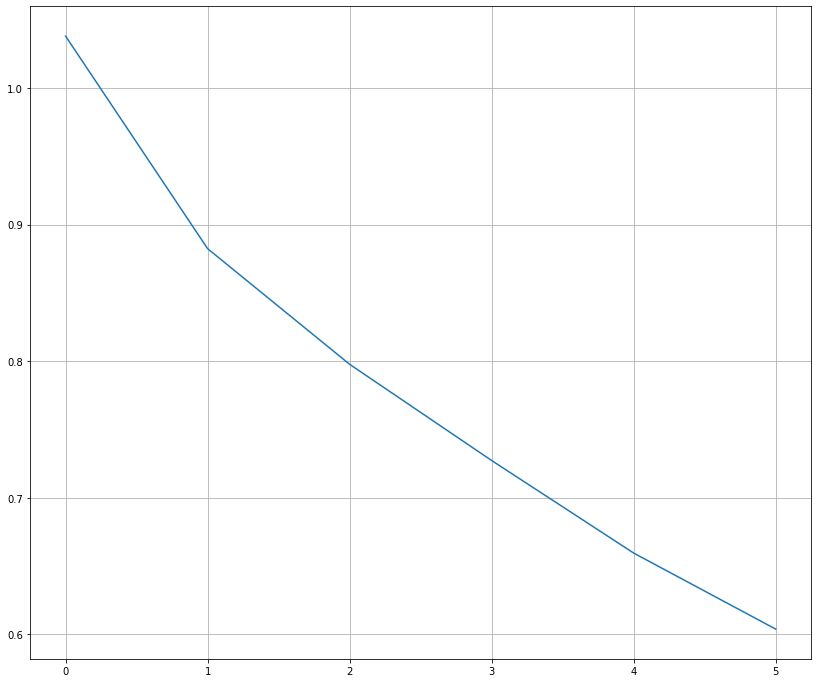

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [ ]:
losses = list()
preds = list()
acc_list = list()

losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)

          

          optimizer.zero_grad()
          # loss.backward()
          optimizer.step()
          losses.append(loss)

          optimizer.zero_grad()
          # loss.backward()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 0.8494126200675964
epoch 1, loss 0.8494126200675964
epoch 2, loss 0.8494126200675964
epoch 3, loss 0.8494126200675964
epoch 4, loss 0.8494126200675964
epoch 5, loss 0.8494126200675964


In [ ]:
losses = list()

# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
for x, y in valid_loader:
    
    with torch.no_grad():
        # получение предсказаний модели
        # расчет лосса
          y_pred = model.forward(x)
          loss = criterion(y_pred, y)
          losses.append(loss)
    

### **CNN**

In [ ]:
class MyCNN(nn.Module):
# c1_in=32, c2_in=64, c2_out=101, l1_out=16384, l2_out=64
  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):

    x = self.embedding_layer(x)
    x = self.conv1(x)
    # print(x.size())
    x = torch.max_pool1d(x, kernel_size=3)
    # print(x.size())
    x = self.relu(x)
    # print(x.size())
    x = self.conv2(x)
    # print(x.size())
    x = x.sum(dim=1)
    # print(x.size())

    x = self.linear_1(x)
    # print(x.size())


    x = torch.relu(x)
    # print(x.size())


    x = self.linear_2(x)
    # print(x.size())
    x = self.dropout(x)

    x = torch.relu(x)
    # print(x.size())
    # print(y.size())
    # переводим с помощью линейного преобразования в количество классов
    # (batch_size, linear_2_size) -> (batch_size, n_classes)
    x = self.linear_3(x)
 

    return x


In [ ]:
model = MyCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))


In [ ]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.8375054597854614
epoch 1, loss 1.494188904762268
epoch 2, loss 1.4907337427139282


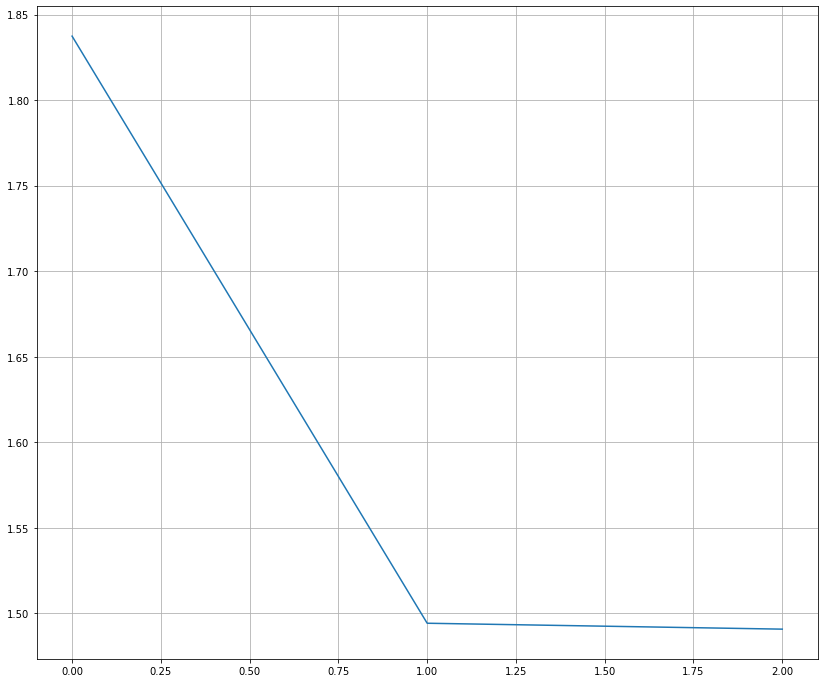

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [ ]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.4907337427139282
epoch 1, loss 1.4907337427139282
epoch 2, loss 1.4907337427139282


In [ ]:
# out1 = cnn1(inp)
# out2 = cnn2(inp)
# full_out = torch.cat([out1, ou2], dim=1) # dim=1 is the channel dimension for 2D images
# full_out = full_out.view(full_out.size(0), -1) # Linearize for the FC

### **PARALLEL CNN**

In [ ]:
class MyParallelCNN(nn.Module):
# c1_in=32, c2_in=64, c2_out=101, l1_out=16384, l2_out=64
  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)

    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):

    x = self.embedding_layer(x)
    x1 = self.conv1(x)
    # print(x.size())
    x1 = torch.max_pool1d(x1,padding=1, kernel_size=3)
    # print(x.size())
   
    # print(x.size())
    x2 = self.conv2(x)
    # print(x.size())
    x2 = torch.avg_pool1d(x2, padding=1, kernel_size=3)
    x = torch.cat([x1, x2], dim=1)
    x = self.relu(x)
    #x = x.sum(dim=1)
    # print(x.size())
    x = self.linear_1(x)
    # print(x.size())
    x = x.sum(dim=1)
    x = torch.relu(x)
    # print(x.size())
    x = self.linear_2(x)
    # print(x.size())
    x = self.dropout(x)
    x = torch.relu(x)
    
    # print(x.size())
    # print(y.size())
    x = self.linear_3(x)
 

    return x

In [ ]:
model = MyParallelCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))

In [ ]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.8084009885787964
epoch 1, loss 1.754172444343567
epoch 2, loss 1.701970100402832


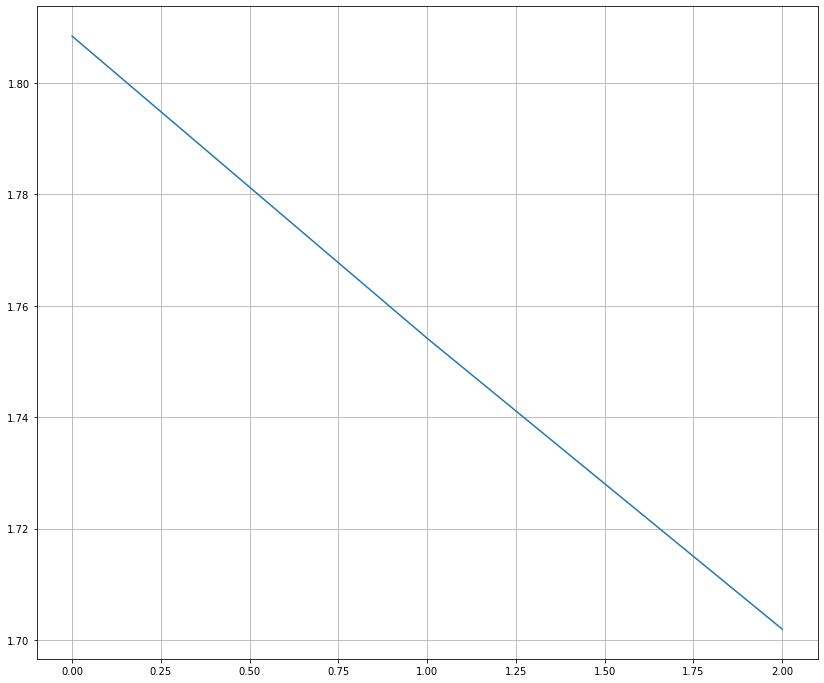

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [ ]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.701970100402832
epoch 1, loss 1.701970100402832
epoch 2, loss 1.701970100402832


### **LSTM**

In [ ]:
# vocab
class LSTM(nn.Module):
    
    def __init__(self, embeddings, hidden_size, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])

        self.lstm = nn.LSTM(input_size=300, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
        # self.hidden = (torch.zeros(1, 1,hidden_size), torch.zeros(1,1,hidden_size))
        
        self.linear_1 = nn.Linear(in_features=256, out_features=32)

        self.linear_2 = nn.Linear(in_features=32, out_features=16)
        self.linear_3 = nn.Linear(in_features=16, out_features=128)
        
    def forward(self, x):
        #print(x.size())
        x = self.embedding_layer(x)
        #print(x.size())

        #print(x.size())

        # x = self.lstm(view(len(seq), 1, -1), self.hidden)
        #print(x.size())
        # x = x.sum(dim=1)
        # x = self.batch_norm(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        
        x = self.linear_3(x)
        
        
        return x

In [ ]:
model = LSTM(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128,
                            hidden_size = 64,
                           n_classes=len(category2index))

In [ ]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [ ]:
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.7242971658706665
epoch 1, loss 1.723311424255371
epoch 2, loss 1.3818469047546387


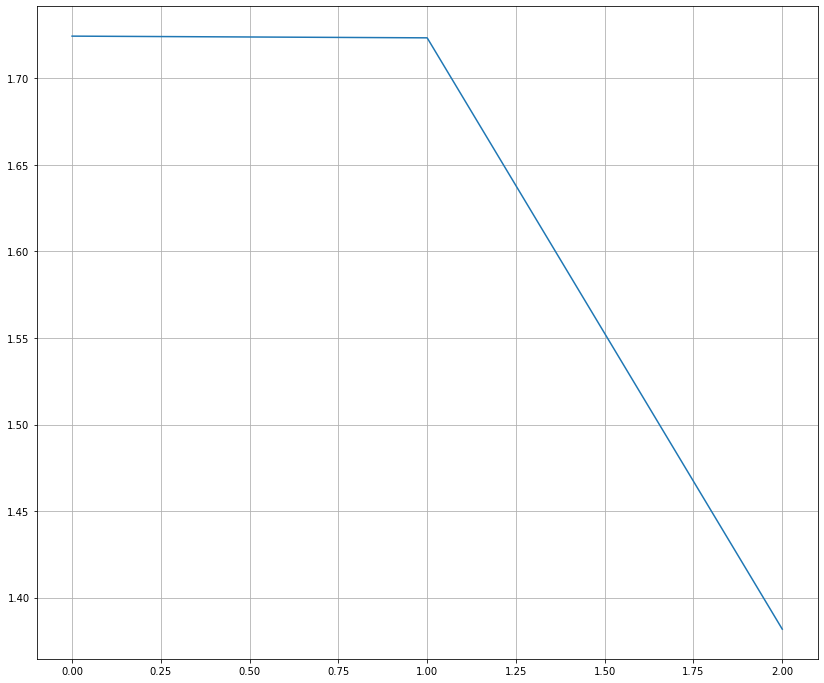

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [ ]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.3818469047546387
epoch 1, loss 1.3818469047546387
epoch 2, loss 1.3818469047546387
